C:\Users\lolo_\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


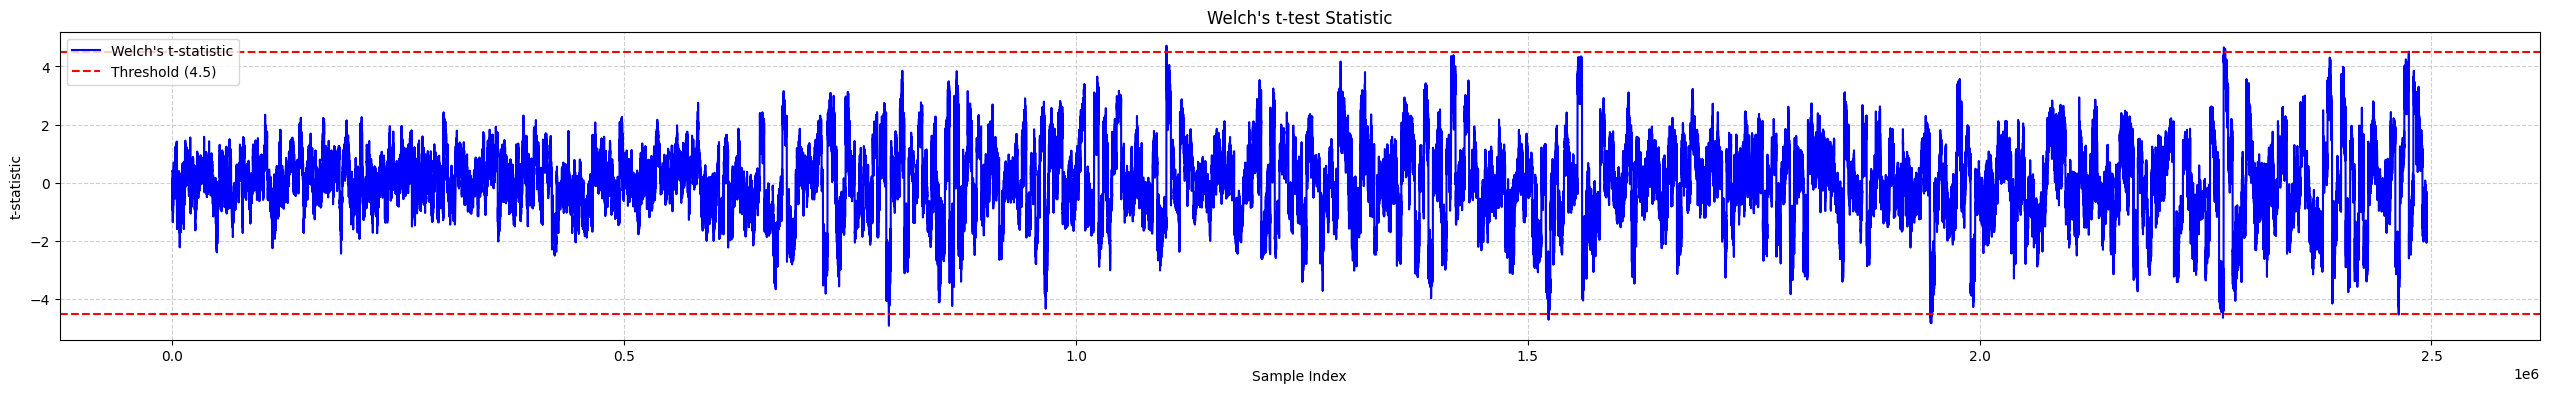

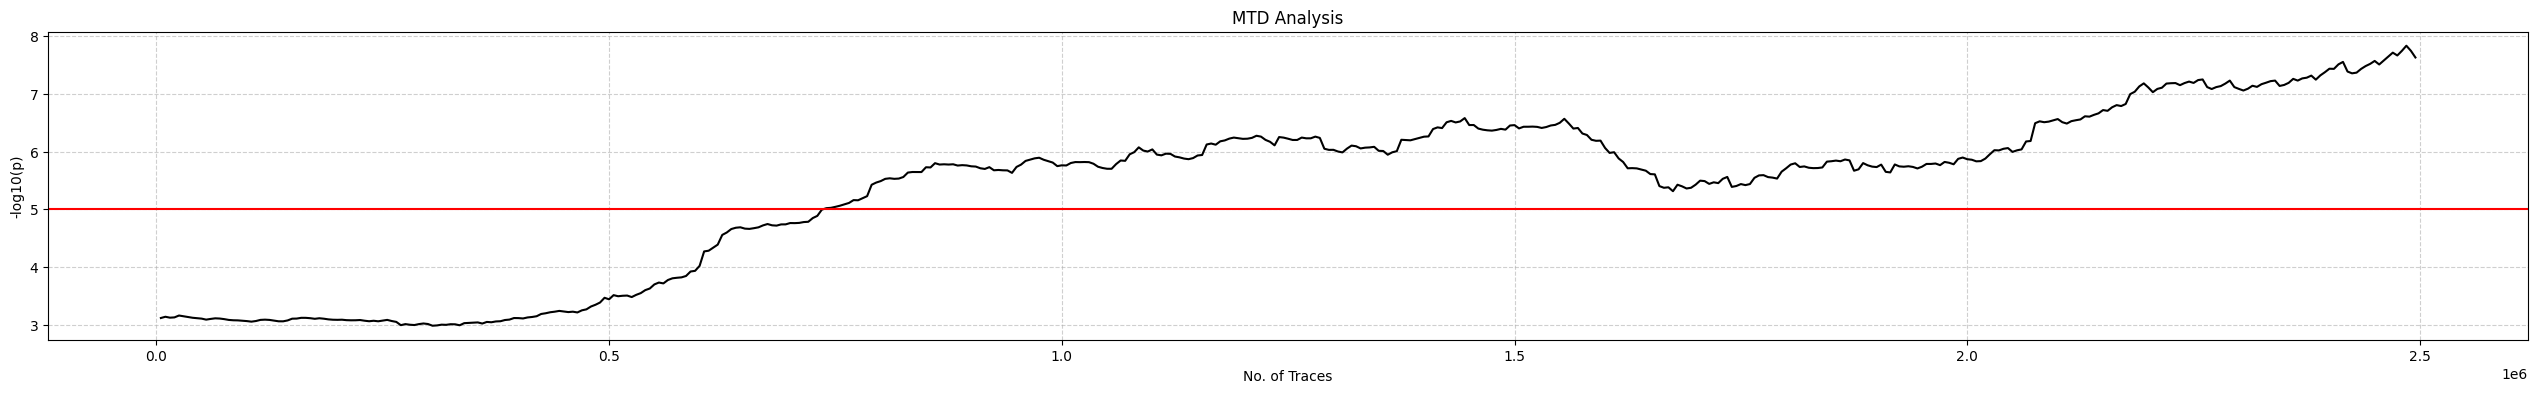

In [1]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from scipy.stats import t

BATCH_SIZE = 5000

def load_zarr_data(file_path, start, batch_size):
    zarr_file = zarr.open(file_path, mode='r')
    end = min(start + batch_size, zarr_file['traces'].shape[0])
    return np.ascontiguousarray(zarr_file['traces'][start:end].astype(np.float32))

@njit(parallel=True)
def Welch_t_test(trace_0, trace_1):
    n0, n1 = trace_0.shape[0], trace_1.shape[0]
    num_points = trace_0.shape[1]

    mean_0 = np.zeros(num_points, dtype=np.float32)
    mean_1 = np.zeros(num_points, dtype=np.float32)
    var_0 = np.zeros(num_points, dtype=np.float32)
    var_1 = np.zeros(num_points, dtype=np.float32)
    t_stat = np.zeros(num_points, dtype=np.float32)

    for i in prange(num_points):
        valid_0 = trace_0[:, i][~np.isnan(trace_0[:, i])]
        valid_1 = trace_1[:, i][~np.isnan(trace_1[:, i])]

        count_0 = valid_0.size
        count_1 = valid_1.size

        if count_0 > 0:
            mean_0[i] = np.sum(valid_0) / count_0
        if count_1 > 0:
            mean_1[i] = np.sum(valid_1) / count_1
        if count_0 > 1:
            var_0[i] = np.sum((valid_0 - mean_0[i]) ** 2) / (count_0 - 1)
        if count_1 > 1:
            var_1[i] = np.sum((valid_1 - mean_1[i]) ** 2) / (count_1 - 1)

        denom = np.sqrt(var_0[i] / n0 + var_1[i] / n1)
        if denom != 0:
            t_stat[i] = (mean_0[i] - mean_1[i]) / denom

    return t_stat, var_0, var_1, n0, n1

def compute_p_value(t_stat, df):
    return 2 * t.sf(np.abs(t_stat), df=df)

def compute_degrees_of_freedom(var_0, var_1, n0, n1):
    numerator = (var_0 / n0 + var_1 / n1) ** 2
    denominator = (var_0 ** 2) / (n0 ** 2 * (n0 - 1)) + (var_1 ** 2) / (n1 ** 2 * (n1 - 1))
    return numerator / denominator

@njit
def moving_average(data, window_size=100):
    smoothed_data = np.zeros_like(data)
    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2)
        smoothed_data[i] = np.mean(data[start:end])
    return smoothed_data

def plot_t_statistic(t_stat, title="Welch's t-test Statistic"):
    plt.figure(figsize=(32, 4))
    plt.plot(t_stat, label="Welch's t-statistic", color='blue')
    plt.axhline(y=4.5, color='r', linestyle='--', label='Threshold (4.5)')
    plt.axhline(y=-4.5, color='r', linestyle='--')
    plt.xlabel("Sample Index")
    plt.ylabel("t-statistic")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_mtd(traces_processed, max_t_metric, title="MTD Plot"):
    plt.figure(figsize=(32, 4))
    plt.plot(traces_processed, max_t_metric, color='black')
    plt.axhline(y=5, color='r', linestyle='-')
    plt.xlabel("No. of Traces")
    plt.ylabel("-log10(p)")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def main():
    file_A = 'cs5_group0_even_compressed.zarr/0/0'
    file_B = 'cs5_group1_even_compressed.zarr/0/0'

    zarr_file_A = zarr.open(file_A, mode='r')
    total_traces = zarr_file_A['traces'].shape[0]
    
    traces_processed = []
    max_t_metric = []
    t_stats_batch = []  

    for start in range(0, total_traces, BATCH_SIZE):
        end = min(start + BATCH_SIZE, total_traces)
        print(f"Processing batch {start} - {end}...", end="\r")

        data_A = load_zarr_data(file_A, start, BATCH_SIZE)
        data_B = load_zarr_data(file_B, start, BATCH_SIZE)

        t_stat, var_0, var_1, n0, n1 = Welch_t_test(data_A, data_B)

        df = compute_degrees_of_freedom(var_0, var_1, n0, n1)
        
        p_values = compute_p_value(t_stat, df)
        max_t = -np.log10(np.min(p_values))

        traces_processed.append(end)
        max_t_metric.append(max_t)

        t_stats_batch.append(t_stat)

 
    flattened_t_stat = np.concatenate(t_stats_batch)
    smoothed_t_stat = moving_average(flattened_t_stat)
    plot_t_statistic(smoothed_t_stat, title="Welch's t-test Statistic")

    smoothed_max_t = moving_average(np.array(max_t_metric))
    plot_mtd(traces_processed, smoothed_max_t, title="MTD Analysis")

if __name__ == "__main__":
    main()


C:\Users\lolo_\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


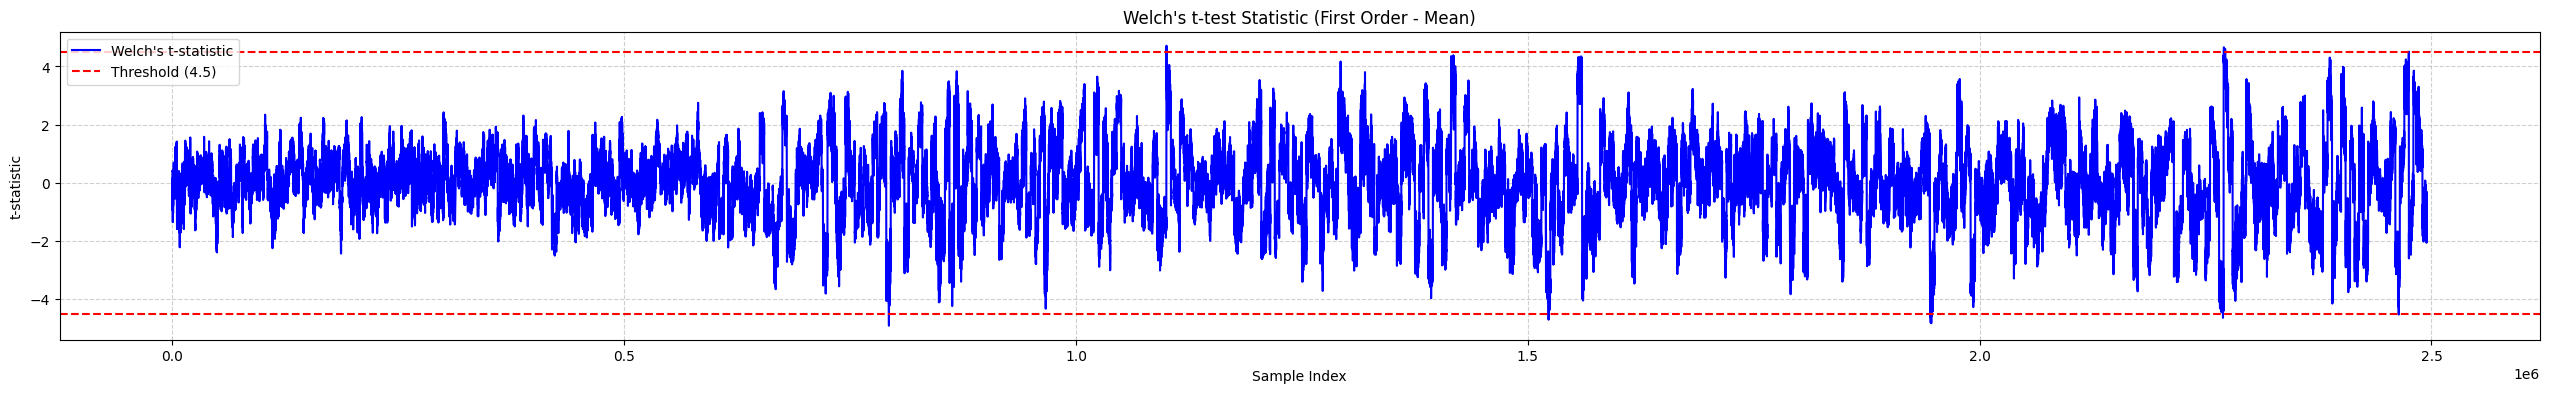

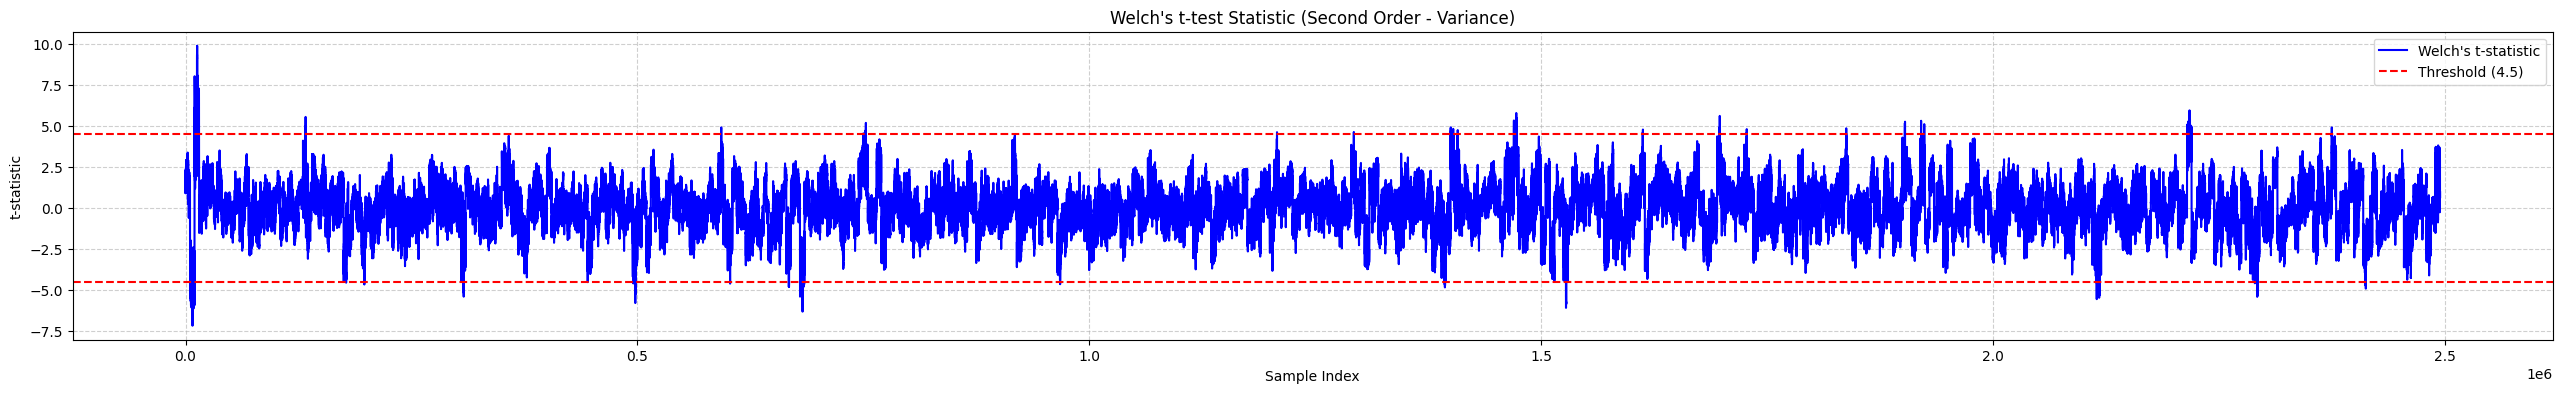

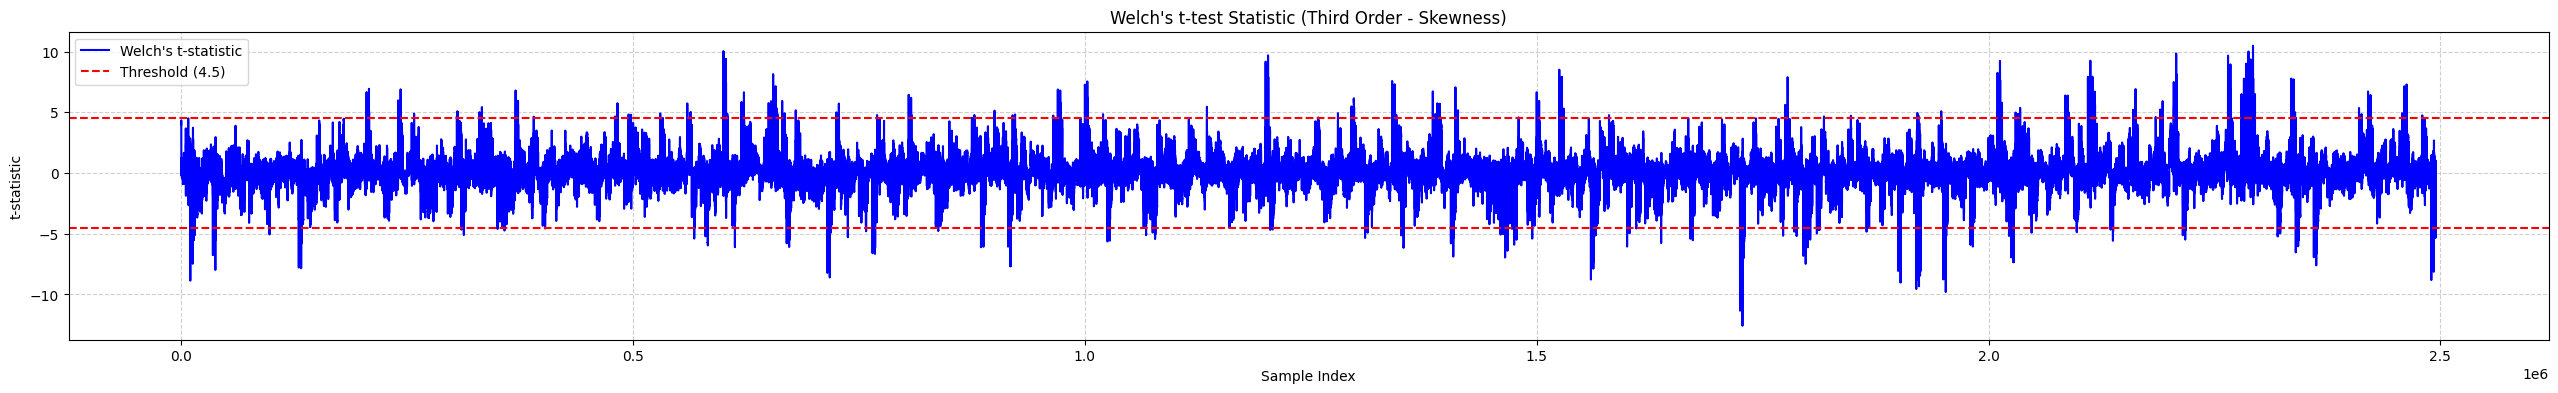

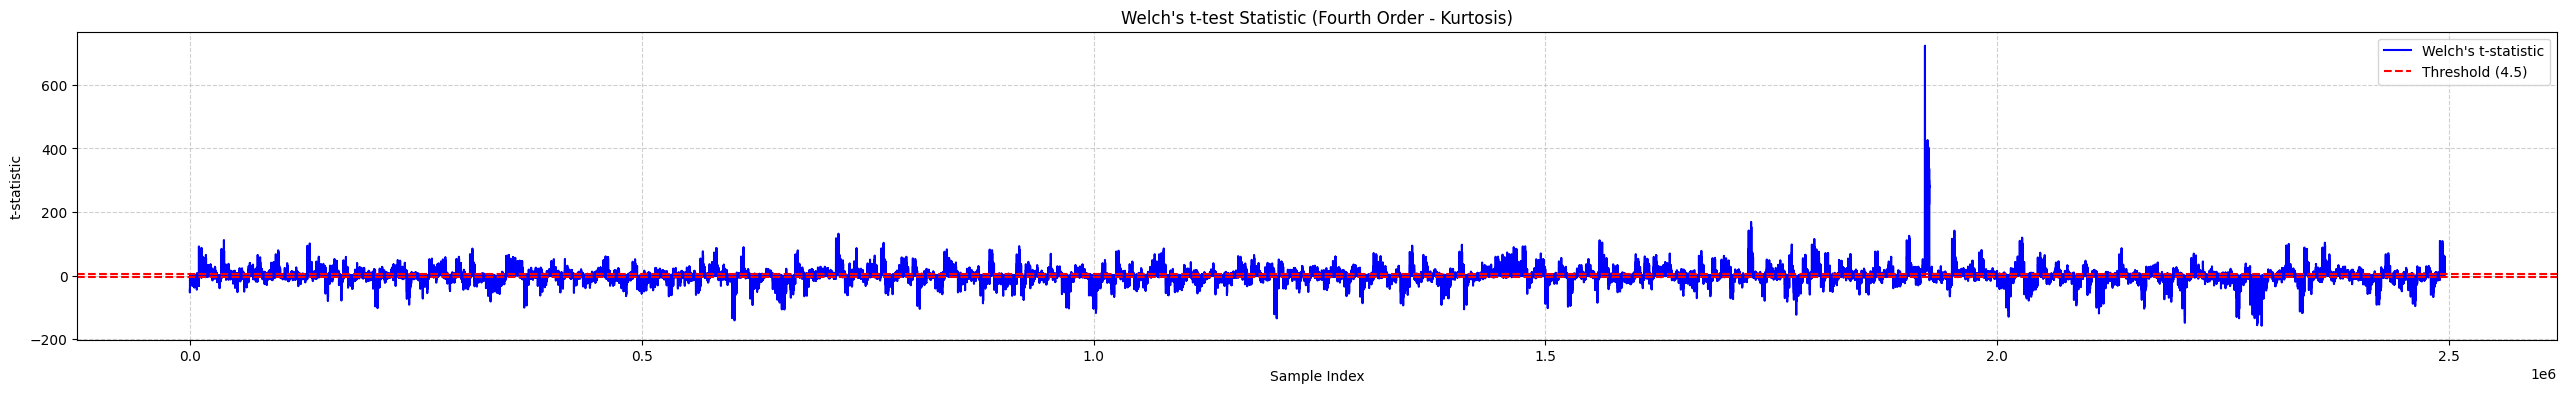

In [2]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

BATCH_SIZE = 5000

def load_zarr_data(file_path, start, batch_size):
    zarr_file = zarr.open(file_path, mode='r')
    end = min(start + batch_size, zarr_file['traces'].shape[0])
    return np.ascontiguousarray(zarr_file['traces'][start:end].astype(np.float32))

@njit(parallel=True)
def Welch_t_test(trace_0, trace_1):
    n0, n1 = trace_0.shape[0], trace_1.shape[0]
    num_points = trace_0.shape[1]

    mean_0 = np.zeros(num_points, dtype=np.float32)
    mean_1 = np.zeros(num_points, dtype=np.float32)
    var_0 = np.zeros(num_points, dtype=np.float32)
    var_1 = np.zeros(num_points, dtype=np.float32)
    skew_0 = np.zeros(num_points, dtype=np.float32)
    skew_1 = np.zeros(num_points, dtype=np.float32)
    kurt_0 = np.zeros(num_points, dtype=np.float32)
    kurt_1 = np.zeros(num_points, dtype=np.float32)
    t_stat_mean = np.zeros(num_points, dtype=np.float32)
    t_stat_var = np.zeros(num_points, dtype=np.float32)
    t_stat_skew = np.zeros(num_points, dtype=np.float32)
    t_stat_kurt = np.zeros(num_points, dtype=np.float32)

    for i in prange(num_points):
        valid_0 = trace_0[:, i][~np.isnan(trace_0[:, i])]
        valid_1 = trace_1[:, i][~np.isnan(trace_1[:, i])]

        count_0 = valid_0.size
        count_1 = valid_1.size

        if count_0 > 0:
            mean_0[i] = np.sum(valid_0) / count_0
        if count_1 > 0:
            mean_1[i] = np.sum(valid_1) / count_1
        if count_0 > 1:
            var_0[i] = np.sum((valid_0 - mean_0[i]) ** 2) / (count_0 - 1)
        if count_1 > 1:
            var_1[i] = np.sum((valid_1 - mean_1[i]) ** 2) / (count_1 - 1)

        
        if count_0 > 2:
            skew_0[i] = np.sum((valid_0 - mean_0[i]) ** 3) / (count_0 * (var_0[i] ** 1.5))
        if count_1 > 2:
            skew_1[i] = np.sum((valid_1 - mean_1[i]) ** 3) / (count_1 * (var_1[i] ** 1.5))

        
        if count_0 > 3:
            kurt_0[i] = np.sum((valid_0 - mean_0[i]) ** 4) / (count_0 * (var_0[i] ** 2)) - 3
        if count_1 > 3:
            kurt_1[i] = np.sum((valid_1 - mean_1[i]) ** 4) / (count_1 * (var_1[i] ** 2)) - 3

        
        denom = np.sqrt(var_0[i] / n0 + var_1[i] / n1)
        if denom != 0:
            t_stat_mean[i] = (mean_0[i] - mean_1[i]) / denom

      
        if denom != 0:
            t_stat_var[i] = (var_0[i] - var_1[i]) / np.sqrt((var_0[i] ** 2) / (n0 - 1) + (var_1[i] ** 2) / (n1 - 1))

    
        t_stat_skew[i] = (skew_0[i] - skew_1[i]) / denom if denom != 0 else 0
        t_stat_kurt[i] = (kurt_0[i] - kurt_1[i]) / denom if denom != 0 else 0

    return t_stat_mean, t_stat_var, t_stat_skew, t_stat_kurt

@njit
def moving_average(data, window_size=100):
    smoothed_data = np.zeros_like(data)
    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2)
        smoothed_data[i] = np.mean(data[start:end])
    return smoothed_data

def plot_t_statistic(t_stat, title="Welch's t-test Statistic"):
    plt.figure(figsize=(32, 4))
    plt.plot(t_stat, label="Welch's t-statistic", color='blue')
    plt.axhline(y=4.5, color='r', linestyle='--', label='Threshold (4.5)')
    plt.axhline(y=-4.5, color='r', linestyle='--')
    plt.xlabel("Sample Index")
    plt.ylabel("t-statistic")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def main():
    file_A = 'cs5_group0_even_compressed.zarr/0/0'
    file_B = 'cs5_group1_even_compressed.zarr/0/0'

    zarr_file_A = zarr.open(file_A, mode='r')
    total_traces = zarr_file_A['traces'].shape[0]
    all_t_stat_mean = np.zeros((total_traces,), dtype=np.float32)
    all_t_stat_var = np.zeros((total_traces,), dtype=np.float32)
    all_t_stat_skew = np.zeros((total_traces,), dtype=np.float32)
    all_t_stat_kurt = np.zeros((total_traces,), dtype=np.float32)

    for start in range(0, total_traces, BATCH_SIZE):
        end = min(start + BATCH_SIZE, total_traces)
        print(f"Processing batch {start} - {end}...", end="\r")

        data_A = load_zarr_data(file_A, start, BATCH_SIZE)
        data_B = load_zarr_data(file_B, start, BATCH_SIZE)

        t_stat_mean, t_stat_var, t_stat_skew, t_stat_kurt = Welch_t_test(data_A, data_B)
        all_t_stat_mean[start:end] = t_stat_mean
        all_t_stat_var[start:end] = t_stat_var
        all_t_stat_skew[start:end] = t_stat_skew
        all_t_stat_kurt[start:end] = t_stat_kurt

   
    smoothed_t_stat_mean = moving_average(all_t_stat_mean)
    smoothed_t_stat_var = moving_average(all_t_stat_var)
    smoothed_t_stat_skew = moving_average(all_t_stat_skew)
    smoothed_t_stat_kurt = moving_average(all_t_stat_kurt)

    
    plot_t_statistic(smoothed_t_stat_mean, title="Welch's t-test Statistic (First Order - Mean)")
    plot_t_statistic(smoothed_t_stat_var, title="Welch's t-test Statistic (Second Order - Variance)")
    plot_t_statistic(smoothed_t_stat_skew, title="Welch's t-test Statistic (Third Order - Skewness)")
    plot_t_statistic(smoothed_t_stat_kurt, title="Welch's t-test Statistic (Fourth Order - Kurtosis)")

if __name__ == "__main__":
    main()
